In [1]:
from fastai.vision.all import *

In [2]:
pd.options.display.max_columns = 100

In [3]:
datapath = Path("/../rsna_data/")
embspath = Path(datapath/"effnet_embs")
train_df = pd.read_csv(datapath/'train.csv')

In [4]:
embfiles = list(embspath.ls())

In [5]:
trainfiles = [o for o in embfiles if 'validation' not in o.stem]
validfiles = [o for o in embfiles  if 'validation' in o.stem]

In [6]:
valid_dict = pd.read_pickle(validfiles[0])

In [7]:
valid_sopids = list(valid_dict.keys())

In [8]:
len(trainfiles)

7

In [9]:
sopid2sid = dict(zip(train_df['SOPInstanceUID'], train_df['StudyInstanceUID']))

In [10]:
len(sopid2sid)

1790594

### Load Embeddings

In [11]:
embeddings = []
sopids = []
for o in trainfiles[:3] + validfiles: # loading all take a lot of time break train files into 2 parts
    embs = pd.read_pickle(o)
    sopids += list(embs.keys())
    embeddings += [np.vstack(list(embs.values()))]

In [12]:
embeddings = np.vstack(embeddings)

In [13]:
embeddings = tensor(embeddings)

In [14]:
# add zero for padded input idx
input_pad_idx = len(embeddings)
embeddings = torch.cat([embeddings, torch.zeros_like(embeddings[:1])])

In [15]:
embeddings

tensor([[ 0.1902, -0.2013,  0.0330,  ..., -0.0989,  0.2165, -0.0236],
        [ 0.1528,  0.0959,  0.3164,  ..., -0.1382,  0.0555,  0.3230],
        [ 0.1278, -0.1890,  0.0270,  ..., -0.1021,  0.0407, -0.0135],
        ...,
        [-0.1743,  0.0427,  0.0098,  ...,  0.1158, -0.0887, -0.0816],
        [-0.1743,  0.0427,  0.0098,  ...,  0.1158, -0.0887, -0.0816],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [16]:
len(sopids), embeddings.shape

(837099, torch.Size([837100, 2048]))

### Metadata Features

In [17]:
metadata_path = datapath/'metadata'
metadata_files = get_files(metadata_path, extensions=".csv")
metadf = pd.concat([pd.read_csv(o) for o in metadata_files]).reset_index(drop=True)

In [18]:
metadf.shape

(1790594, 68)

In [19]:
len(metadf['StudyInstanceUID'].unique())

7279

In [20]:
def minmax_scaler(o): return (o - min(o))/(max(o) - min(o))

In [21]:
scaled_pos = metadf.groupby('StudyInstanceUID')['ImagePositionPatient2'].apply(minmax_scaler)
metadf.loc[:,'scaled_position'] = scaled_pos.values

In [22]:
meta_feat_cols = ['scaled_position']

In [23]:
assert np.isnan(metadf[meta_feat_cols]).sum().sum() == 0

In [24]:
mean_std = metadf[meta_feat_cols].agg(['mean', 'std']).T

In [25]:
mean_std_dict = dict(zip(mean_std.index, mean_std.values.tolist())); mean_std_dict

{'scaled_position': [0.5078721739409284, 0.29139548181397823]}

In [26]:
# standard scaler for training
for c in mean_std_dict: metadf[c] = (metadf[c] - mean_std_dict[c][0]) / mean_std_dict[c][1]

In [27]:
meta_feats_dict = dict(zip(metadf['SOPInstanceUID'], metadf[meta_feat_cols].to_numpy()))

In [28]:
len(meta_feats_dict)

1790594

In [29]:
metadf = metadf.sort_values(['StudyInstanceUID', 'ImagePositionPatient2']).reset_index(drop=True)

In [30]:
metadf['SliceIndexNo'] = metadf.groupby('StudyInstanceUID').cumcount()

In [31]:
metadf[['StudyInstanceUID', 'ImagePositionPatient2', 'SliceIndexNo']].head(10)

,StudyInstanceUID,ImagePositionPatient2,SliceIndexNo
0,8.9406e+09,-366.00,0
1,8.9406e+09,-364.75,1
2,8.9406e+09,-363.50,2
3,8.9406e+09,-362.25,3
4,8.9406e+09,-361.00,4
5,8.9406e+09,-359.75,5
6,8.9406e+09,-358.50,6
7,8.9406e+09,-357.25,7
8,8.9406e+09,-356.00,8
9,8.9406e+09,-354.75,9


In [32]:
sopid2slice_no = dict(zip(metadf['SOPInstanceUID'], metadf['SliceIndexNo']))

### Compute P(pos img | slice id & pos exam)

### Fold Metadata

In [33]:
meta_embeddings = []
for sopid in sopids:
    meta_embeddings.append(meta_feats_dict[sopid])
meta_embeddings = np.vstack(meta_embeddings)
meta_embeddings= tensor(meta_embeddings)

In [34]:
meta_embeddings.shape, type(meta_embeddings)

(torch.Size([837099, 1]), torch.Tensor)

In [35]:
meta_embeddings = torch.cat([meta_embeddings, torch.zeros_like(meta_embeddings[:1])])

In [36]:
embeddings.shape, meta_embeddings.shape

(torch.Size([837100, 2048]), torch.Size([837100, 1]))

In [37]:
combined_embeddings = torch.cat([embeddings, meta_embeddings], 1)

In [38]:
combined_embeddings.shape

torch.Size([837100, 2049])

In [39]:
combined_embeddings

tensor([[ 0.1902, -0.2013,  0.0330,  ...,  0.2165, -0.0236, -1.7429],
        [ 0.1528,  0.0959,  0.3164,  ...,  0.0555,  0.3230, -1.7429],
        [ 0.1278, -0.1890,  0.0270,  ...,  0.0407, -0.0135, -1.7315],
        ...,
        [-0.1743,  0.0427,  0.0098,  ..., -0.0887, -0.0816,  1.6728],
        [-0.1743,  0.0427,  0.0098,  ..., -0.0887, -0.0816,  1.6889],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

### Data

In [40]:
from fastai.text.all import *

In [41]:
image_targets = ['pe_present_on_image']
exam_targets = [
    'negative_exam_for_pe', # exam level
    'rv_lv_ratio_gte_1', # exam level
    'rv_lv_ratio_lt_1', # exam level
    'leftsided_pe', # exam level
    'chronic_pe', # exam level
    'rightsided_pe', # exam level
    'acute_and_chronic_pe', # exam level
    'central_pe', # exam level
    'indeterminate' # exam level
]

In [42]:
targets_df = train_df[['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID']+image_targets+exam_targets]

In [43]:
targets_dict = dict(zip(targets_df['SOPInstanceUID'].values, targets_df[image_targets+exam_targets].values))

In [44]:
len(targets_dict)

1790594

In [45]:
files_dict = defaultdict(list)
for i,sopid in enumerate(sopids):
    sid = sopid2sid[sopid]
    slice_no = sopid2slice_no[sopid]
    files_dict[sid].append({"slice_no":slice_no, "embs_idx":i, "img_y":targets_dict[sopid][0], "exam_y":targets_dict[sopid][1:]})

In [46]:
all_pids = list(files_dict.keys())

In [47]:
len(all_pids)

3397

In [48]:
valid_pids = {sopid2sid[o] for o in valid_sopids}

In [49]:
len(valid_pids)

485

In [50]:
def get_x(pid, files_dict):
    o = files_dict[pid]    
    l = sorted(o, key=lambda x: x['slice_no']) 
    return tensor([o['embs_idx'] for o in l])

def get_img_y(pid, files_dict):
    o = files_dict[pid]    
    l = sorted(o, key=lambda x: x['slice_no']) 
    img_y = [o['img_y'] for o in l]
    img_y = tensor(img_y).float()
    return img_y

def get_exam_y(pid, files_dict):
    d = files_dict[pid][0]        
    exam_y = tensor(d['exam_y']).float()
    return exam_y
    
# before_batch: after collecting samples before collating
targ_pad_idx = 666
def SequenceBlock():       return  TransformBlock(type_tfms=[partial(get_x, files_dict=files_dict)], 
                                                  dl_type=SortedDL,
                                                  dls_kwargs={'before_batch':
                                                               [partial(pad_input, pad_idx=input_pad_idx),
                                                                partial(pad_input, pad_idx=targ_pad_idx, pad_fields=1)]})
def SequenceTargetBlock(): return TransformBlock(type_tfms=[partial(get_img_y, files_dict=files_dict)])
def TargetBlock():         return TransformBlock(type_tfms=[partial(get_exam_y, files_dict=files_dict)])

In [51]:
get_img_y(all_pids[0], files_dict)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [52]:
get_exam_y(all_pids[0], files_dict)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [53]:
# normalized_embeddings = F.normalize(combined_embeddings, dim=0)
# normalized_embeddings.isnan().sum()
# normalized_embeddings

In [54]:
# assert combined_embeddings.isnan().sum().item() == 0

### Model

In [55]:
device = default_device(); device

device(type='cuda', index=0)

In [56]:
class AWD_LSTM(Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182"
    initrange=0.1

    def __init__(self, emb_sz,n_hid, n_layers, hidden_p=0.2, input_p=0.6, weight_p=0.5, bidir=False):
        store_attr('emb_sz,n_hid,n_layers')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
        
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid)//self.n_dir, bidir, weight_p, l) for l in range(n_layers)])

        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])
        self.reset()

    def forward(self, x, from_embeds=False):
        
        if from_embeds: inp = x
        else: inp = combined_embeddings[x].to(device)
        bs,sl = inp.shape[:2]
        if bs!=self.bs: self._change_hidden(bs)

        output = self.input_dp(inp)
        new_hidden = []
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            output, new_h = rnn(output, self.hidden[l])
            new_hidden.append(new_h)
            if l != self.n_layers - 1: output = hid_dp(output)
        self.hidden = to_detach(new_hidden, cpu=False, gather=False)
        return output

    def _change_hidden(self, bs):
        self.hidden = [self._change_one_hidden(l, bs) for l in range(self.n_layers)]
        self.bs = bs

    def _one_rnn(self, n_in, n_out, bidir, weight_p, l):
        "Return one of the inner rnn"
        rnn = nn.LSTM(n_in, n_out, 1, batch_first=True, bidirectional=bidir, bias=False)
        return WeightDropout(rnn, weight_p)

    def _one_hidden(self, l):
        "Return one hidden state"
        nh = (self.n_hid) // self.n_dir
        return (one_param(self).new_zeros(self.n_dir, self.bs, nh), one_param(self).new_zeros(self.n_dir, self.bs, nh))

    def _change_one_hidden(self, l, bs):
        if self.bs < bs:
            nh = (self.n_hid) // self.n_dir
            return tuple(torch.cat([h, h.new_zeros(self.n_dir, bs-self.bs, nh)], dim=1) for h in self.hidden[l])
        if self.bs > bs: return (self.hidden[l][0][:,:bs].contiguous(), self.hidden[l][1][:,:bs].contiguous())
        return self.hidden[l]

    def reset(self):
        "Reset the hidden states"
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]

In [57]:
layers = [512 * 3] + [512] + [9]

class MultiHeadedSequenceClassifier(Module):
    "dim: input sequence feature dim"
    def __init__(self, bptt=72, input_pad_idx=input_pad_idx, n_meta=1, dim=1024):
        
        store_attr('input_pad_idx')
        self.awd_lstm = AWD_LSTM(dim+n_meta, 512, 2, bidir=True)
        self.encoder = SentenceEncoder(bptt=bptt, module=self.awd_lstm, pad_idx=input_pad_idx)
        
        # image level preds
        self.seq_head = LinearDecoder(1, 512, bias=True)
 
        # exam level preds
        self.exam_head = PoolingLinearClassifier(layers, ps=[0.4, 0.1], bptt=bptt)
        
    
    def forward(self, x):
        out, mask = self.encoder(x) 
       
        # img level out
        seq_cls_out,_,_ = self.seq_head(out)
        seq_cls_out = seq_cls_out.squeeze(-1)
              
        # exam level out
        exam_out,_,_ = self.exam_head((out,mask))

        return (seq_cls_out, exam_out)

In [58]:
class MultiLoss(Module):
    
    def __init__(self, targ_pad_idx=666):
        store_attr("targ_pad_idx")

    def forward(self, inp, yb0, yb1):
        exam_target_weights = tensor([0.0736196319, 0.2346625767,  0.0782208589, 
                                      0.06257668712, 0.1042944785, 0.06257668712,
                                      0.1042944785,  0.1877300613, 0.09202453988]).to(yb1.device)
        seq_cls_out, exam_out = inp
       
        # img loss
        mask = yb0 != self.targ_pad_idx 
        
        img_loss, qs = 0, 0        
        for _m,_y,_p in zip(mask, yb0, seq_cls_out):
            qi = _y[_m].mean()
            qs += qi*sum(_m)
            img_loss += qi*(F.binary_cross_entropy_with_logits(_p[_m], _y[_m], reduction='sum'))
        
        # exam loss
        exam_losses = F.binary_cross_entropy_with_logits(exam_out, yb1,reduction='none')
        tot_exam_loss = (exam_losses*(exam_target_weights.unsqueeze(0))).sum()
        tot_exam_wgts = len(exam_losses)*(tensor(exam_target_weights).sum())
        
        return (tot_exam_loss+img_loss)/(qs+tot_exam_wgts)

### Train

In [62]:
part = 0

In [66]:
data = DataBlock(blocks=(SequenceBlock,SequenceTargetBlock,TargetBlock), 
                 n_inp=1, splitter=FuncSplitter(lambda o: True if o in valid_pids else False))
dls = data.dataloaders(all_pids, bs=64)
model = SequentialRNN(MultiHeadedSequenceClassifier(bptt=256, dim=2048))
loss_func = MultiLoss()
learner = Learner(dls, model, loss_func=loss_func, metrics=[], cbs=[ModelResetter(), 
                                                                    TerminateOnNaNCallback(),
                                                                    SaveModelCallback(fname=f"effnet_nometa_sequence_model_no{part}")])
# learner.to_fp16();

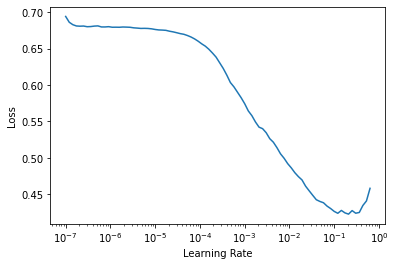

In [64]:
# learner.lr_find();

In [ ]:
learner.fit_flat_cos(40, lr=0.01)

In [ ]:
part = 0 # top 3 train embeddings

In [ ]:
learner.save(f"effnet_nometa_sequence_model_no{part}", with_opt=False)

### Get Preds

In [ ]:
part = 0

In [192]:
learner.load(f"effnet_nometa_sequence_model_no{part}");

In [193]:
learner.model.eval().to(device);

In [194]:
len(all_pids)

1456

In [195]:
test_dl = learner.dls.test_dl(all_pids)

In [196]:
seq_img_preds = []
seq_exam_preds = []
with torch.no_grad():
    for xb in progress_bar(test_dl.dataset):
        img_pred, exam_pred = to_detach(learner.model(xb[0][None,...].cuda()))
        seq_img_preds.append(img_pred)
        seq_exam_preds.append(exam_pred)

In [197]:
folddir

Path('/../rsna_data/cnn_embs/full_512_FOLD3')

In [198]:
torch.save(seq_img_preds, folddir/'seq_img_preds.pth')
torch.save(seq_exam_preds, folddir/'seq_exam_preds.pth')
torch.save(all_pids, folddir/'pids.pth')